# Exercício Física Moderna Teleporte

## Discente: Alice Ferreira Silva

In [1]:
from qiskit import *
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
#qiskit.__qiskit_version__

In [2]:
# Nesta implementação usou-se 3 qubits e 2 bist clássicos
qr = QuantumRegister(3, name="q")    # Definição de 3 qubits
crz = ClassicalRegister(1, name="crz") # Definição 2 bits clássicos
crx = ClassicalRegister(1, name="crx") # em 2 registradores diferentes
teleportation_circuit = QuantumCircuit(qr, crz, crx)

Criaremos um par de Bell. Transfere-se um dos qubits para a base X (|+⟩ e |−⟩) usando a porta Hadamard e, em seguida, aplica-se uma porta CNOT no outro qubit controlado por aquele na base X.

In [3]:
def _par_de_bell(qc, a, b):
    qc.h(a) # Colocando o qubit no estado |+>
    qc.cx(a,b) # CNOT com A como controle e B como alvo

Vamos definir que q_1 pertence a Alice e Bob possui o q_2.


Na comunicação feita por Alice aplica-se uma porta CNOT, controlada por |ψ⟩, que é o qubit que ela está tentando enviar para Bob. Em seguida, aplica-se a Hadamard em |ψ⟩.

In [4]:
def alice_porta(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [5]:
# Definição do par de Bell
_par_de_bell(teleportation_circuit, 1, 2)

teleportation_circuit.barrier() # Apenas melhorando a visualização
alice_porta(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

Agora, Alice aplica uma medida a ambos os qubits que ela possui, até então são: q_1 e |ψ⟩. Em seguida, o resultado é armazenado em dois bits clássicos. Esses dois bits são enviados para Bob.

In [6]:
def measure_and_send(qc, a, b):
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [7]:
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

Bob, já possui o qubit q_2, então, dependendo do estado dos bits clássicos, aplica-se as seguintes portas:

00 → Não é feito nata

01 → Aplica-se a porta X

10 → Aplica-se a porta Z

11 → Aplica-se a porta ZX

Essa decisão é feita na função a seguir.

In [8]:
def bob_porta(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)

In [9]:
teleportation_circuit.barrier() # Usando barrier para separar os passos
bob_porta(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                  ║  ║       │   ┌──┴──┐
crz: 1/═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                  0  ║    ┌──┴──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

Para esta execução, o qubit de Alice foi inicializado no estado |ψ⟩ =  |𝑖−⟩.

In [10]:
psi = [1,0]

Criamos a porta de incialização para criar |ψ⟩ a partir do estado |0⟩:

In [11]:
init_gate = Initialize(psi)
init_gate.label = "init"
inverse_init_gate = init_gate.gates_to_uncompute()

Vamos provar que o qubit |q_0⟩ foi teletransportado para |q_2⟩. Abaixo, revertemos a inicialização de |q_2⟩, esperando medir o estado |0⟩.

In [12]:
teleportation_circuit.append(inverse_init_gate, [2])

# Mostrar circuito
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░                               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────────────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░                               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────────────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ ┌──────────────┐
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─┤ disentangler ├
            └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ └──────────────┘
                                  ║  ║       │   ┌──┴──┐                
crz: 1/═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞════════════════
                                  0  ║    ┌──┴──┐└─────┘                
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════════════════════
                                     0    └─────┘

In [13]:
# Para mostrar o resultado, necessita-se adicionar um novo ClassicalRegister
cr_result = ClassicalRegister(1)
teleportation_circuit.add_register(cr_result)
teleportation_circuit.measure(2,2)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░                                  
  q_0: ───────────░───■──┤ H ├─░─┤M├────░──────────────────────────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░                                  
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░──────────────────────────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ ┌──────────────┐┌─┐
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─┤ disentangler ├┤M├
            └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ └──────────────┘└╥┘
                                  ║  ║       │   ┌──┴──┐                 ║ 
crz: 1/═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞═════════════════╬═
                                  0  ║    ┌──┴──┐└─────┘                 ║ 
crx: 1/══════════════════════════════╩════╡ = 1 ╞════════════════════════╬═
                                     0    └─────┘                        ║ 
 c0: 1/══════════════════════════════════════════════════════════════════╩═
                                                                         0

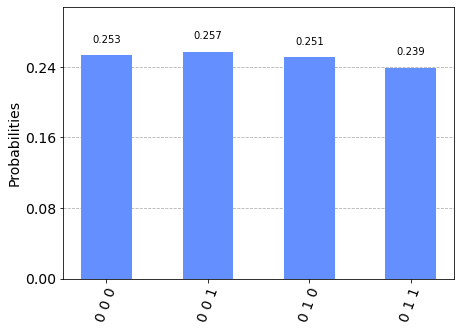

In [14]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(teleportation_circuit, backend, shots=1024).result().get_counts()
plot_histogram(counts)

Concluímos que temos 100% chance de medir q_2, no estado |0⟩. Sendo assim, provamos que o protocolo de teletransporte funcionou corretamente.

Referências:

https://qiskit.org/textbook/ch-algorithms/superdense-coding.html

https://qiskit.org/textbook/ch-states/single-qubit-gates.html

https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html

https://qiskit.org/textbook/ch-algorithms/teleportation.html